In [33]:
import torch
import random
import math
import hess
import hess.utils as utils
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
from hess.data import data_loader
import numpy as np
import copy

In [34]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [35]:
X, Y = twospirals(500, noise=1.5)
test_x, test_y = twospirals(100, 1.5)

In [36]:
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y).unsqueeze(-1)

In [37]:
loss_func = torch.nn.BCEWithLogitsLoss()

In [38]:
use_cuda =  torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()

In [39]:
n_trial = 100
pct_keep = .35
optim = torch.optim.Adam

losses = torch.zeros(n_trial)
test_losses = torch.zeros(n_trial)
hessians = []

for tt in range(n_trial): 
    
    model = hess.nets.MaskedNet(train_x, train_y, bias=True, 
                            n_hidden=5, hidden_size=10,
                            activation=torch.nn.ELU(),
                            pct_keep=pct_keep)
    n_par = sum(p.numel() for p in model.parameters())
    if use_cuda:
        model = model.cuda()
    mask, perm = hess.utils.mask_model(model, pct_keep, use_cuda)
    keepers = np.array(np.where(mask.cpu() == 1))[0]
        
    ## compute the hessian of the masked network ##
    sub_hess = torch.zeros(n_par, n_par)
    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0)
        base_vec[0, pp] = 1.

        base_vec = utils.unflatten_like(base_vec, model.parameters())
        utils.eval_hess_vec_prod(base_vec, model.parameters(),
                                net=model,
                                criterion=torch.nn.BCEWithLogitsLoss(),
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = utils.gradtensor_to_tensor(model, include_bn=True)
            sub_hess = torch.zeros(output.nelement(), output.nelement())
            sub_hess[:, pp] = output


        sub_hess[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()
    
    mask = hess.utils.get_mask(model)
    ## extract the indices of the hessian we care about ##
    keepers = np.array(np.where(mask == 1))[0]
    hessians.append(sub_hess[np.ix_(keepers, keepers)])

#     optimizer=optim(model.parameters(), lr=lr)

#     for step in range(n_iters):
#         optimizer.zero_grad()
#         outputs = model(train_x)

#         loss=loss_func(outputs,train_y)
#         losses[tt, step] = loss
#         loss.backward()
#         optimizer.step()
        
#         test_out = model(test_x)
#         test_loss = loss_func(test_out, test_y)


    ## now compute the losses for the subnetwork ##
    outputs = model(train_x)
    losses[tt] = loss_func(outputs, train_y)
    
    outputs = model(test_x)
    test_losses[tt] = loss_func(outputs, test_y)
    
    if tt%10 == 0:
        print("model ", tt, " done")

model  0  done
model  10  done
model  20  done
model  30  done
model  40  done
model  50  done
model  60  done
model  70  done
model  80  done
model  90  done


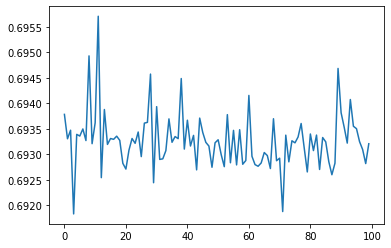

In [40]:
plt.plot(losses.detach())

In [41]:
idx = losses.argsort()
sorted_losses = losses[idx]

In [42]:
idx

tensor([ 3, 71, 29, 12, 87, 79, 43, 83, 20, 67, 48, 52, 63, 56, 62, 58, 98, 19,
        88, 64, 54, 73, 86, 69, 59, 31, 32, 70, 25, 61, 66, 51, 65, 33, 81, 21,
        97, 39, 78, 47, 41, 14, 99,  9, 23, 92, 75, 49, 46, 35, 85, 96, 74,  7,
        18, 50, 16,  1, 37, 15, 22, 84, 76, 36, 17,  5, 42, 72, 82,  4, 80, 45,
        24, 55,  2, 57,  6, 95, 91, 94, 77, 26, 10, 27, 40, 34, 68, 44, 53,  0,
        90, 13, 30, 93, 60, 38, 28, 89,  8, 11])

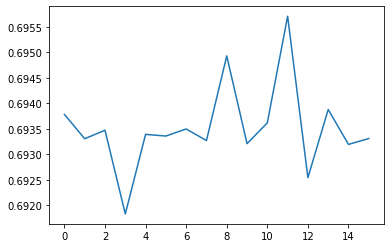

In [43]:
plt.plot(losses[:16].detach())

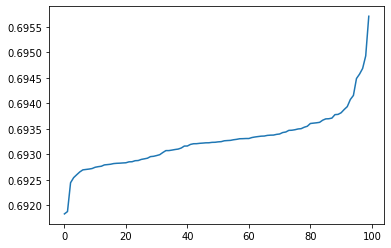

In [44]:
plt.plot(sorted_losses.detach())

In [45]:
e_vals = []
for tt in range(n_trial):
    e_val, _ = np.linalg.eig(hessians[tt].cpu())
    tidx = np.abs(e_val).argsort()[::-1]   
    e_val = torch.FloatTensor(e_val[tidx].real)
    e_vals.append(e_val)

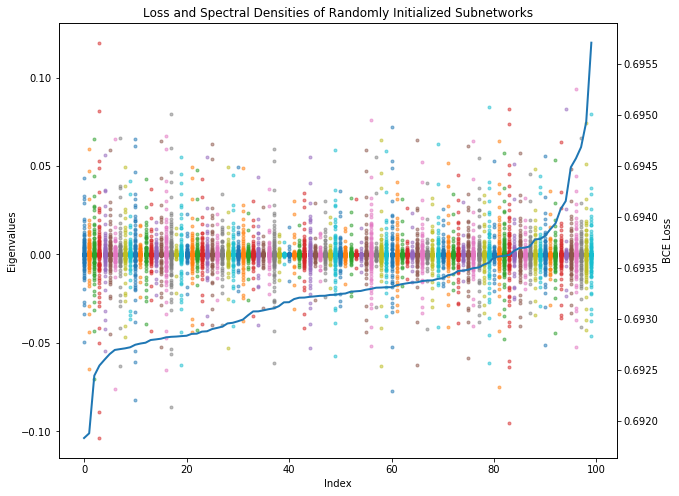

In [46]:
fig, ax1 = plt.subplots(figsize=(10,8))
for ii, tt in enumerate(idx):
    ax1.plot(torch.ones_like(e_vals[tt]) * ii, e_vals[tt],
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Eigenvalues")


ax2 = ax1.twinx()
ax2.plot(sorted_losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Spectral Densities of Randomly Initialized Subnetworks");

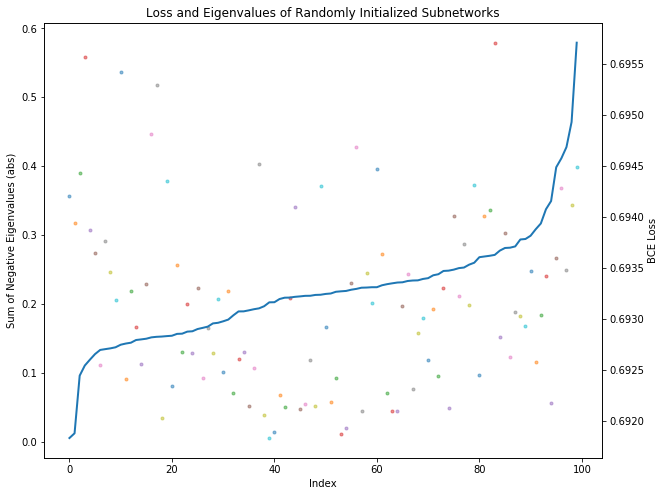

In [47]:
fig, ax1 = plt.subplots(figsize=(10,8))
for ii, tt in enumerate(idx):
    ax1.plot(ii, sum(e_vals[int(tt)][e_vals[int(0)] < 0].abs()),
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Sum of Negative Eigenvalues (abs)")


ax2 = ax1.twinx()
ax2.plot(sorted_losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Eigenvalues of Randomly Initialized Subnetworks");

In [48]:
e_vals[0]

tensor([ 4.4442e-02,  3.7996e-02,  3.4924e-02, -2.9011e-02, -1.8191e-02,
        -1.5575e-02,  1.4866e-02, -1.3061e-02, -1.2536e-02,  1.1688e-02,
         9.9859e-03, -9.9054e-03,  9.0472e-03, -8.0766e-03,  7.6306e-03,
        -7.0980e-03, -6.7836e-03,  6.3718e-03, -6.2534e-03, -5.4149e-03,
         5.4104e-03, -5.1490e-03,  4.7530e-03,  3.7226e-03, -3.6760e-03,
        -3.5332e-03,  3.3432e-03, -2.9653e-03,  2.8705e-03, -2.7016e-03,
        -2.6217e-03,  2.4139e-03, -2.3791e-03,  2.2402e-03, -2.0159e-03,
         1.9700e-03,  1.8644e-03, -1.4471e-03,  1.4319e-03, -1.3326e-03,
        -1.3065e-03,  1.1478e-03, -1.0467e-03, -1.0060e-03, -8.4331e-04,
         8.1105e-04, -7.7197e-04, -7.3321e-04, -6.8636e-04,  6.1453e-04,
         4.7944e-04, -3.9429e-04,  3.5929e-04, -3.3895e-04, -3.1645e-04,
         2.9818e-04, -2.6534e-04,  2.4765e-04, -2.1085e-04, -1.7303e-04,
         1.4528e-04, -1.3164e-04, -9.6983e-05,  7.7234e-05, -7.4276e-05,
         5.7787e-05, -5.3936e-05, -4.7909e-05,  4.5

In [49]:
outputs = optimus(train_x.cpu())
outputs = torch.zeros_like(outputs)
ll = loss_func(outputs, train_y.cpu())

NameError: name 'optimus' is not defined

In [ ]:
ss = 0
for tsr in model.parameters():
    print(tsr.shape)
    ss += tsr.numel()

In [ ]:
ss

In [ ]:
out = hess.utils.unflatten_like(mask.unsqueeze(0), model.parameters())

In [ ]:
for tsr in out:
    print(tsr.shape)